<a href="https://colab.research.google.com/github/sameepshrestha/segmentation_state_of_the_art/blob/main/best_architecture_with_resnet_18_with_skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jul  2 15:24:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 43kB/s 
     |████████████████████████████████| 471kB 39.5MB/s 
     |████████████████████████████████| 2.9MB 12.5MB/s 
     |████████████████████████████████| 3.8MB 38.5MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [3]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-8rtcbhwl
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-8rtcbhwl
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp37-none-any.whl size=20049 sha256=6f754e507d59bcbf3cf521c78fd5927f59e804ed85bb15ac0ed41368016f1dd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxkdfoqv/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [4]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 as cv 
from PIL import Image, ImageDraw
import json 
import os 
import glob 
import re 
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate,MaxPooling2D, AveragePooling2D,Input, BatchNormalization, Activation, UpSampling2D, Concatenate, LeakyReLU,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Multiply,SpatialDropout2D,Add
from tensorflow.keras.optimizers import Adam, SGD
#using tensorflow backend 16 so keras backend still 32bytes so no keras to be used
# from keras.layers.merge import concatenate,Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet import ResNet50
import gc
import psutil
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [5]:
# model.summary()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def Augmentation(images,mask):
    def _transform(image,mask):
        transform=A.Compose([
         A.HorizontalFlip(p=0.5),
         A.Rotate([-20,20],p=.25),
    ])
        aug=transform(image=image,mask=mask)
        img=aug['image']
        img=tf.cast(img,tf.float32)
        msk=aug['mask']
        msk=tf.cast(msk,tf.float32)
        return img,msk
    image,mask=tf.numpy_function(_transform,[images,mask],[tf.float32,tf.float32])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 38])
    
    return image,mask
AUTO = tf.data.experimental.AUTOTUNE
Image_width = 640 
Image_height = 480 
no_classes =38
def load_data(path, split=0.2):
    images = sorted(glob.glob(os.path.join(path, "image/*")))
    print(len(images))
    masks = sorted(glob.glob(os.path.join(path, "mask2/*")))
    print(len(masks))
    total_size = 7990
    test_size = 1705
    valid_size=1000
    training_x, test_x = train_test_split(images[:7990], test_size=test_size, random_state=42)
    training_y, test_y = train_test_split(masks[:7990], test_size=test_size, random_state=42)
    train_x, valid_x = train_test_split(training_x, test_size=valid_size, random_state=50)
    train_y, valid_y = train_test_split(training_y, test_size=valid_size, random_state=50)
    return (train_x, train_y), (valid_x, valid_y),(test_x, test_y)
(train_x,train_y),(valid_x,valid_y),(test_x, test_y)=load_data('/content/drive/MyDrive/depth')
train_size=len(train_x)
valid_size=len(valid_x)

def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_NEAREST)
  
    x = to_categorical(x,num_classes=no_classes)
    x = x[:,:,:]
    x=tf.cast(x,dtype=tf.float32)
    return x
# read_mask('/content/drive/MyDrive/depth/mask100/mask1.png')
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float32,tf.float32])
    x.set_shape([Image_height, Image_width, 3])
    y.set_shape([Image_height, Image_width, no_classes])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)

    dataset = dataset.repeat()
    dataset = dataset.shuffle(96, seed =0)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO)
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=8)
valid_dataset=tf_dataset(valid_x,valid_y,batch=8)
valid_dataset

8033
8033


<PrefetchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 38)), types: (tf.float32, tf.float32)>

In [7]:
def encoder(inputs):
    skip_layers = []
    model2 = ResNet18(include_top=False,weights='imagenet',input_tensor=inputs)
    x = model2.get_layer('relu1').output
    names = ['bn0','stage2_unit1_bn1','stage3_unit1_bn1','stage4_unit1_bn1']
    for name in names:
        layer = model2.get_layer(name).output
        skip_layers.append(layer)
    return x,skip_layers
def transistion_conv(x,filter=256):
    x = Conv2D(filter,(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    return x 
def decoder_conv(x,y_1,filters = 64):
    # print(x.shape)
    y = Conv2D(filters,(3,3), padding="same")(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters,(3,3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Add()([y_1,y])
    y_1 = y
    y = Activation('relu')(y)
    return y,y_1
def decoder(x,skip_layers):
    filters  = [256,128,64,64,64]
    skip_layers.reverse()
    for i in range(len(filters)-1):
        if i in [0,1,2,3]:
            x = Add()([x,skip_layers[i]])
            y_1 = x
            x = Activation('relu')(x)
        x,y_1 = decoder_conv(x,y_1,filters[i])
        x,y_1 = decoder_conv(x,y_1,filters[i])
        x = transistion_conv(x,filters[i+1])
    x = Activation('relu')(x)
    return x
def outputs(input):
    x = Conv2D(64,(3,3), padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(38,(1,1), padding="same")(x)
    return x 
def main_model(shape):
    inputs = Input(shape)
    encoded,skip_layers = encoder(inputs)
    transistioned = transistion_conv(encoded) 
    decoded = decoder(transistioned,skip_layers)
    output = outputs(decoded)
    model = Model(inputs,output)
    return model 
shape = (480,640,3)
model = main_model(shape)
model.summary()

44924928/44920640 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 480, 640, 3)  9           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 486, 646, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 240, 320, 64) 9408        zero_padding2d[0][0]             
___________________________

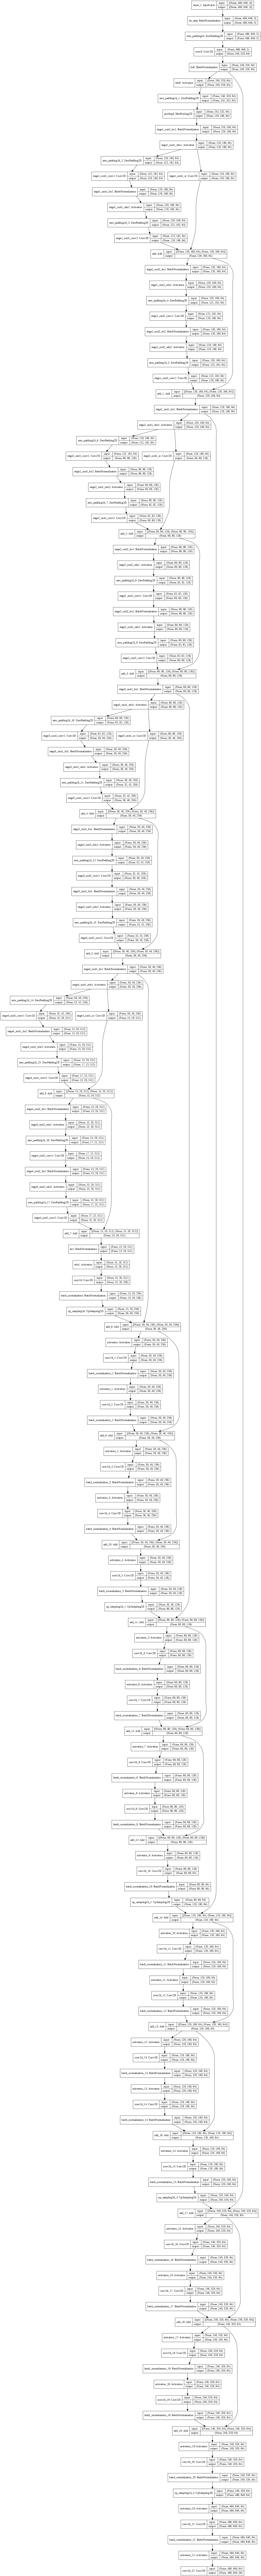

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [9]:
#loss function 
import gc 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger ,LearningRateScheduler,Callback
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
    def on_train_batch_end(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = self.schedule(batch, lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nbatch %05d: Learning rate is %8f." % (batch, scheduled_lr))
def lr_scheduler(batch,lr):
      t_steps = train_size//8
      
    #   if (i+13+12+6)> 30:
    #     lr =0.00000025347102
    #     return lr
      batch = (i+13)*t_steps+batch
      lr = .001 *((1- (batch/(t_steps*50)))**.9)
      return lr
def lr_schedule(i):
      t_steps = train_size//8
      batch = (i+13)*t_steps+1
      lr = .001 *((1- (batch/(t_steps*50)))**.9)
      return lr
def binary_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred,from_logits=True)
    loss_value = tf.math.reduce_mean(loss,axis=[0])
    return loss_value

def cross_entropy_loss(y_true,y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(
    y_true, y_pred, axis=-1, name=None)
    return loss

def custom_metrics(y_true,y_pred,smooth=1):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    # y_pred = tf.expand_dims(y_pred,axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_true = y_true[:,:,:,1:38]
    y_pred= y_pred[:,:,:,1:38]
    intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
    union = (tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3])) - intersection
    return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
metrics = tf.keras.metrics.MeanIoU(
    37
)
def custom_metrics2(y_true,y_pred):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_pred = tf.reshape(y_pred,[-1,38])
    y_true = tf.reshape(y_true,[-1,38])
    return metrics(y_true,y_pred)

smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
model=tf.keras.models.load_model( '/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/Resnet18_with_skip/all/',custom_objects={
        'cross_entropy_loss': cross_entropy_loss,'custom_metrics':custom_metrics })

In [ ]:
lr =.001
# model.compile(loss = cross_entropy_loss,optimizer = Adam(learning_rate =lr,beta_1= 0.9),metrics = [custom_metrics])
epoch=24
t_steps = train_size//8
v_steps=valid_size//8
val_custom_metrics = 0.416
val_metrics =[]
for i in range(epoch):
  print('epoch =',i+1)
  lr = lr_schedule(i)
  model.compile(loss = cross_entropy_loss,optimizer=SGD(learning_rate =lr,momentum= 0.9),metrics=[custom_metrics])
  model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps,callbacks=[CustomLearningRateScheduler(lr_scheduler)])
#   model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps,callbacks=[CustomLearningRateScheduler(lr_scheduler)])
  loss = model.evaluate(valid_dataset,steps=v_steps)
  model.save('/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/Resnet18_with_skip/all/',save_format='tf')
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    model.save('/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/Resnet18_with_skip/best/',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

Streaming output truncated to the last 5000 lines.
 42/660 [>.............................] - ETA: 13:03 - loss: 1.1868 - custom_metrics: 0.4863
batch 00041: Learning rate is 0.000630.
 43/660 [>.............................] - ETA: 13:02 - loss: 1.1869 - custom_metrics: 0.4859
batch 00042: Learning rate is 0.000630.
 44/660 [=>............................] - ETA: 13:01 - loss: 1.1869 - custom_metrics: 0.4856
batch 00043: Learning rate is 0.000630.
 45/660 [=>............................] - ETA: 12:59 - loss: 1.1867 - custom_metrics: 0.4853
batch 00044: Learning rate is 0.000630.
 46/660 [=>............................] - ETA: 12:58 - loss: 1.1866 - custom_metrics: 0.4851
batch 00045: Learning rate is 0.000630.
 47/660 [=>............................] - ETA: 12:57 - loss: 1.1864 - custom_metrics: 0.4848
batch 00046: Learning rate is 0.000630.
 48/660 [=>............................] - ETA: 12:55 - loss: 1.1862 - custom_metrics: 0.4846
batch 00047: Learning rate is 0.000630.
 49/660 [=>